In [9]:
# import _imports
from typing import (List, Tuple, Dict, Callable, Union)

import pandas as pd
import numpy as np

import get_dataset

import warnings

warnings.filterwarnings("ignore")

# 数据获取

In [3]:
# 数据获取
get_dataset.get_data('all')

数据获取(起始日:2013-01-01,结束日:2022-02-28
开始划分高低端象限...


高低端象限数据获取完毕!
开始划分四象限...


四象限数据获取完毕!
开始获取因子数据...


因子数据获取完毕!
开始获取收盘价数据...


收盘价数据获取完毕!


# 读取数据

In [10]:
dichotomy, quandrant, factors_frame, pricing = get_dataset.load_data()

dichotomy.csv文件读取完毕!
quandrant_df.csv文件读取完毕!
factors_frame.csv文件读取完毕!
pricing.csv文件读取完毕!


# 因子分析

## 高低端因子分析

In [2]:
from analyze_func import get_factor_res
from plotting import plotting_dichotomy_res
from my_scr import (quadrant_dic, dichotomy_dic)

In [4]:
# 获取roe高端/低端,营收高端/低端的数据
res = get_factor_res(dichotomy,
                     factors_frame,
                     pricing,
                     dichotomy_dic,
                     group_num=3)

可以看到低ROE端因子单调性都较好

- ILLIQ_20D:第三组（高分组）收益较好，但IC较低为1.79%(分组中最低,较为异常)；
- RealizedSkewness_240D:第一组(低分组)收益较好,IC为3.05%(分组中最高)；
- VolAvg_20D_240D:第一组(低分组)收益较好,IC为-0.34%(分组中最低,较为异常)；
- VolCV_20D:第一组(低分组)收益较好,IC为-2.63%(分组中最高)；



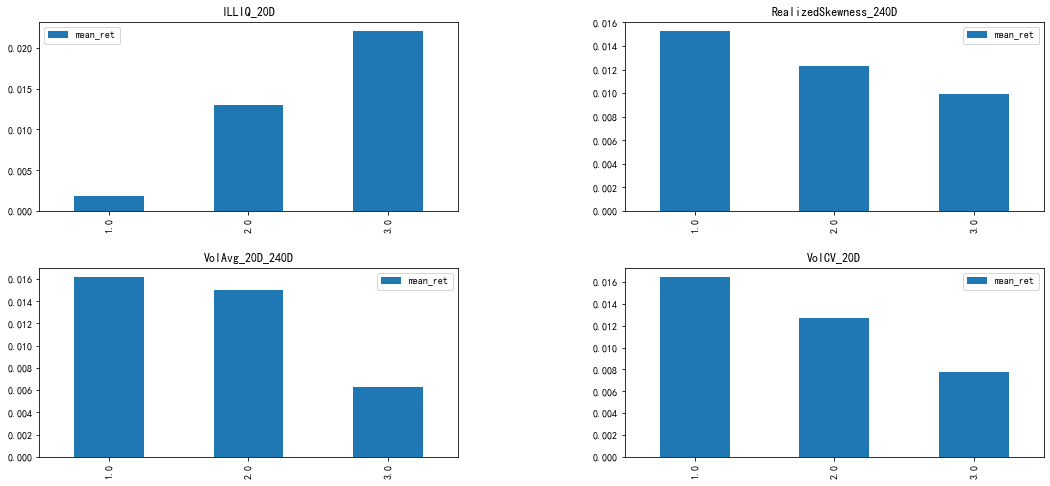

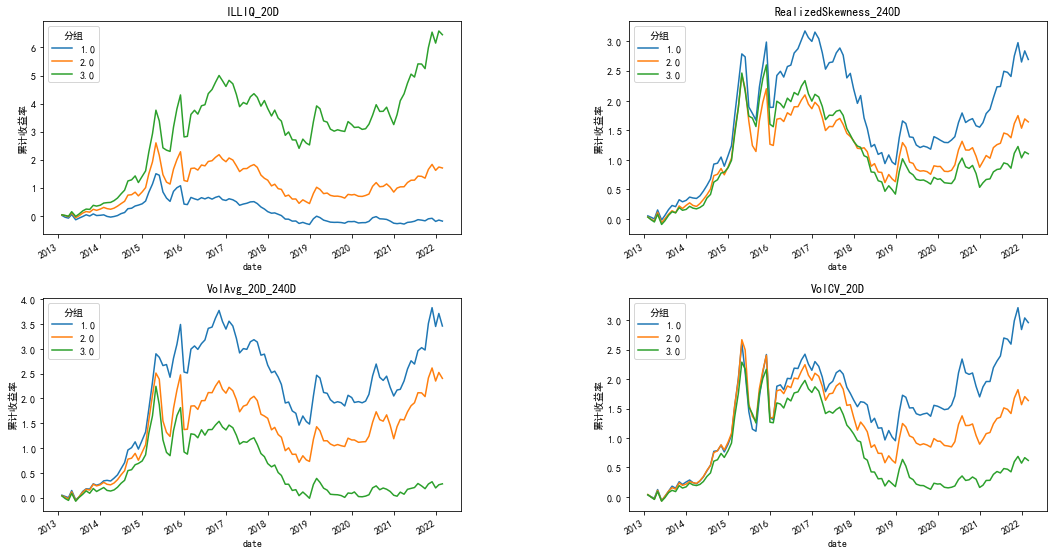

In [5]:
plotting_dichotomy_res(res['低roe端'])

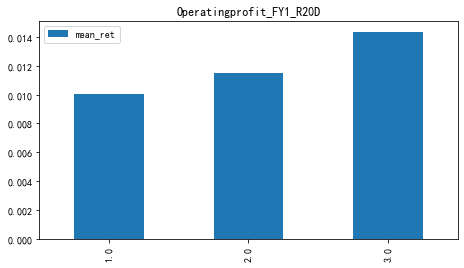

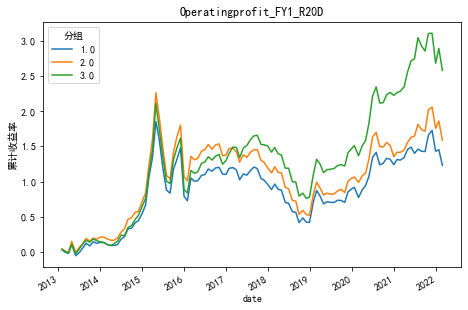

In [6]:
plotting_dichotomy_res(res['高roe端'])

低增长端因子单调性较好
- Gross_profit_margin_chg:第三组收益较高(高分组),IC为-1.27%(分组中最低,较为异常);
- Netprofit_chg:第三组收益较高(高分组),IC为-1.64%(分组绝对值最高);

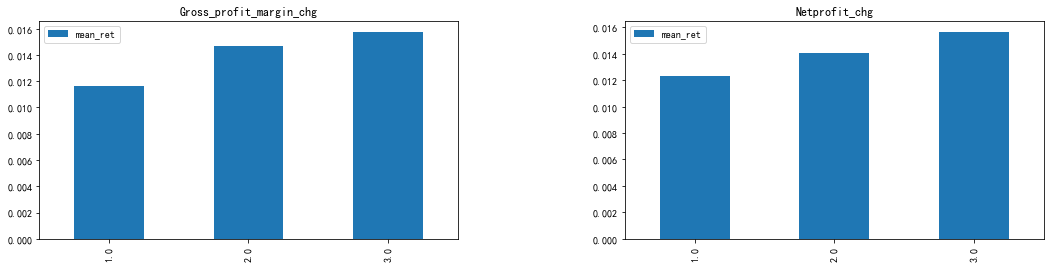

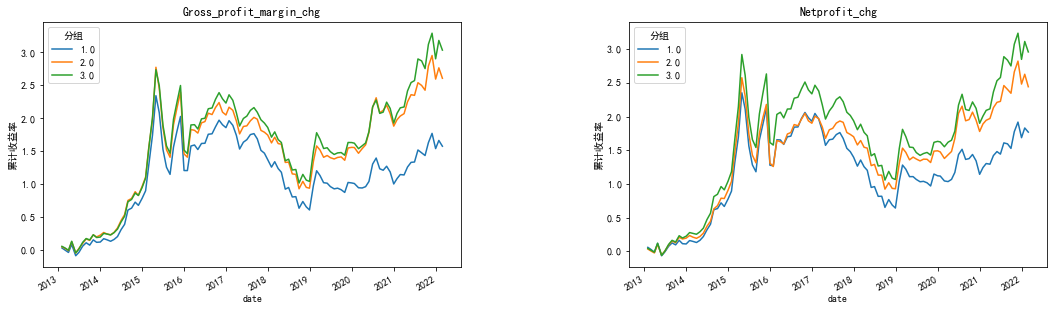

In [7]:
plotting_dichotomy_res(res['低增长端'])

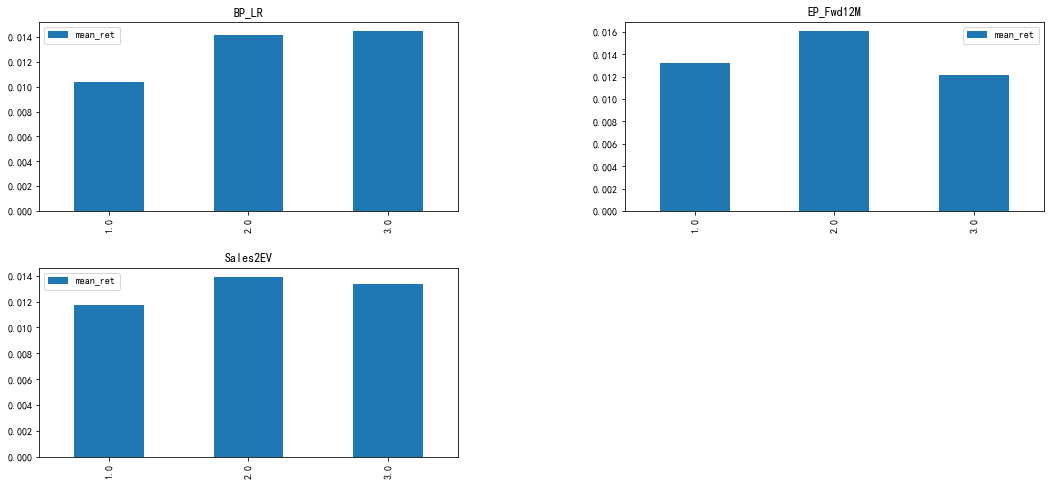

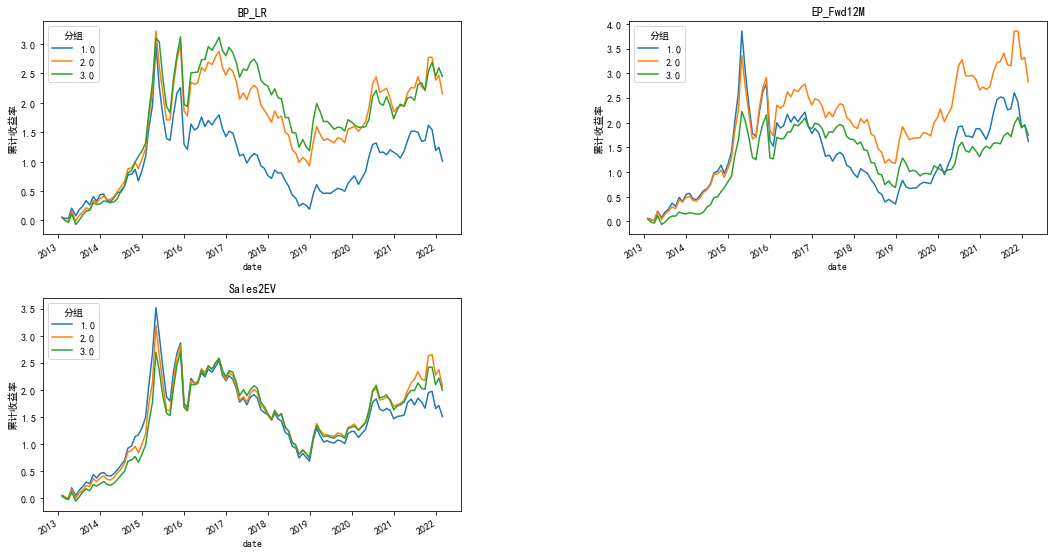

In [8]:
plotting_dichotomy_res(res['高增长端'])

## 四象限因子复合

In [9]:
# 获取roe高端/低端,营收高端/低端的数据

stack_quandrant = quandrant.stack().to_frame('cat_type')
res1 = get_factor_res(stack_quandrant,
                      factors_frame,
                      pricing,
                      quadrant_dic,
                      group_num=3)


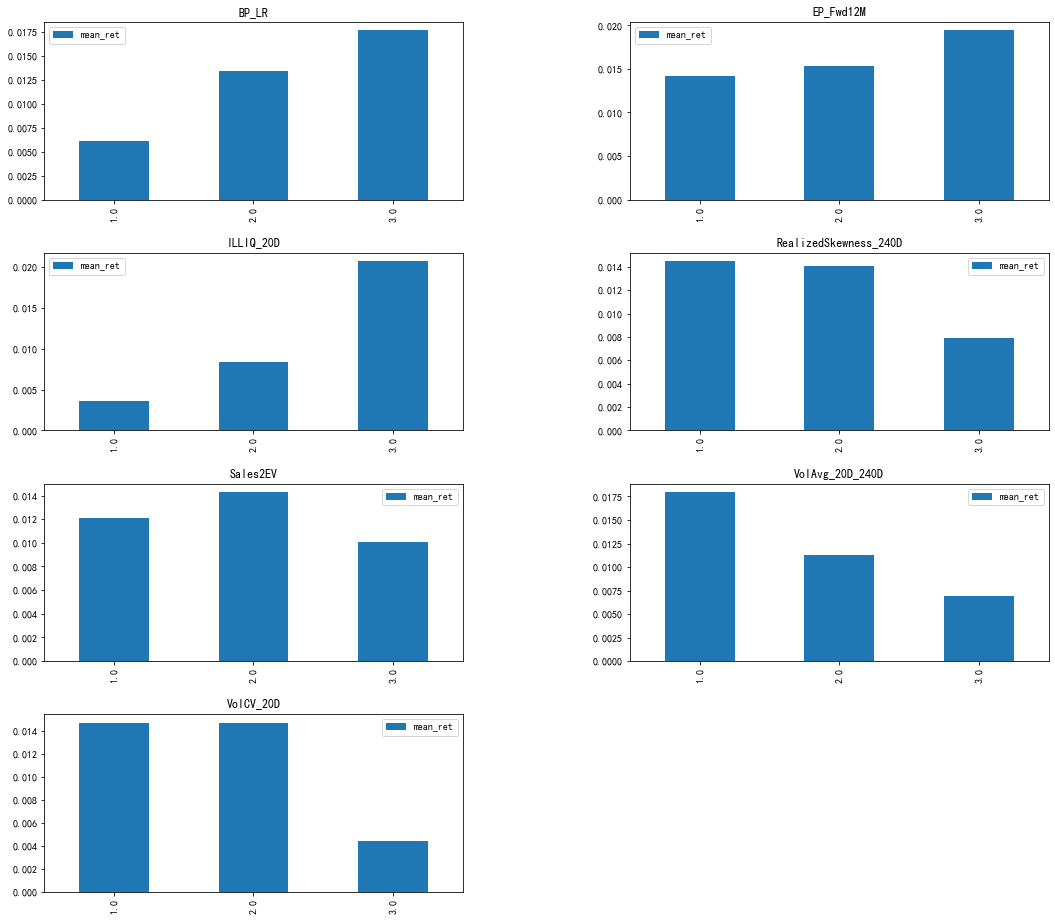

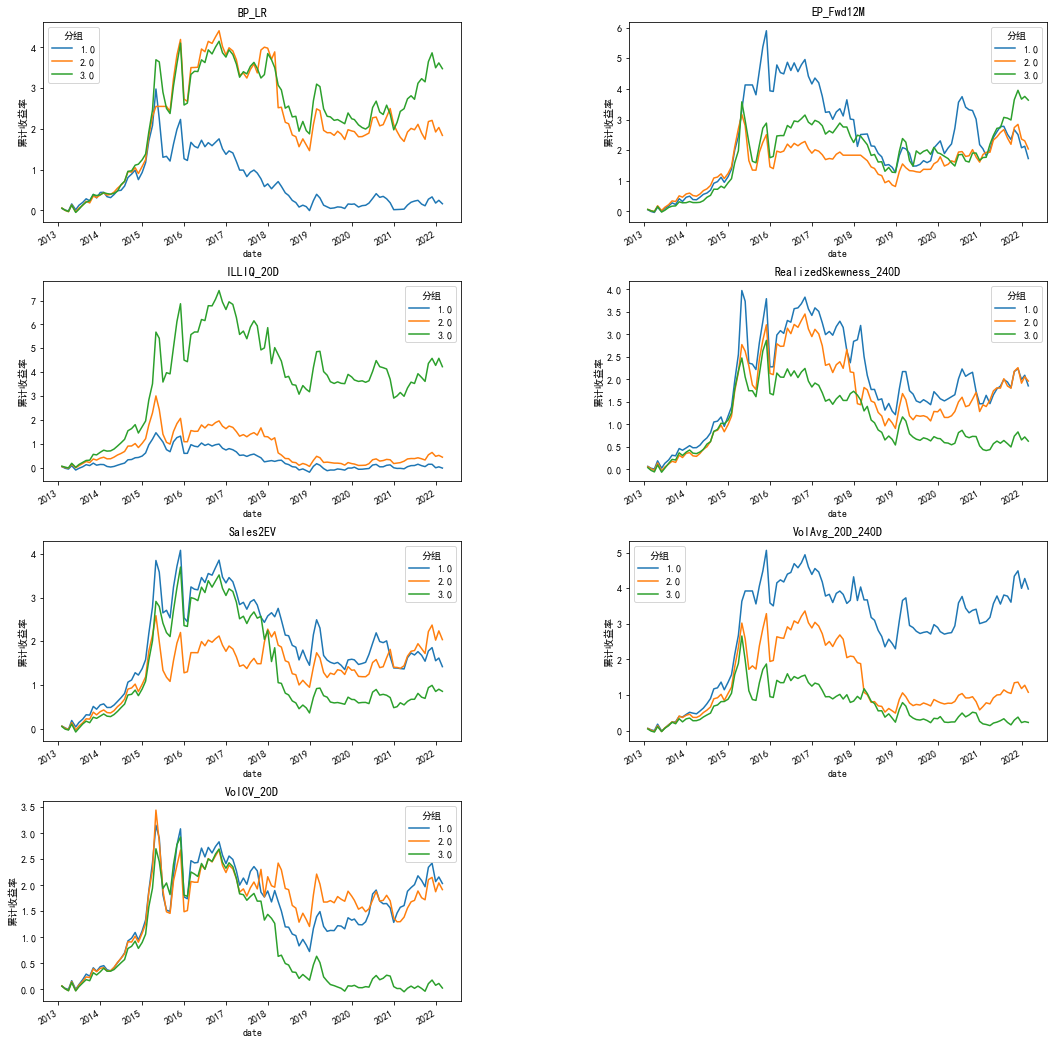

In [10]:
plotting_dichotomy_res(res1['导入期'])

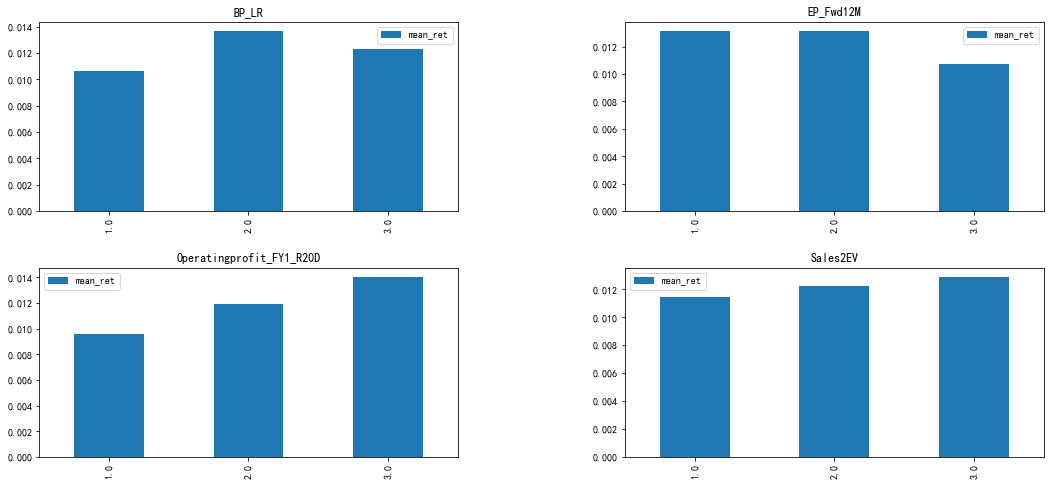

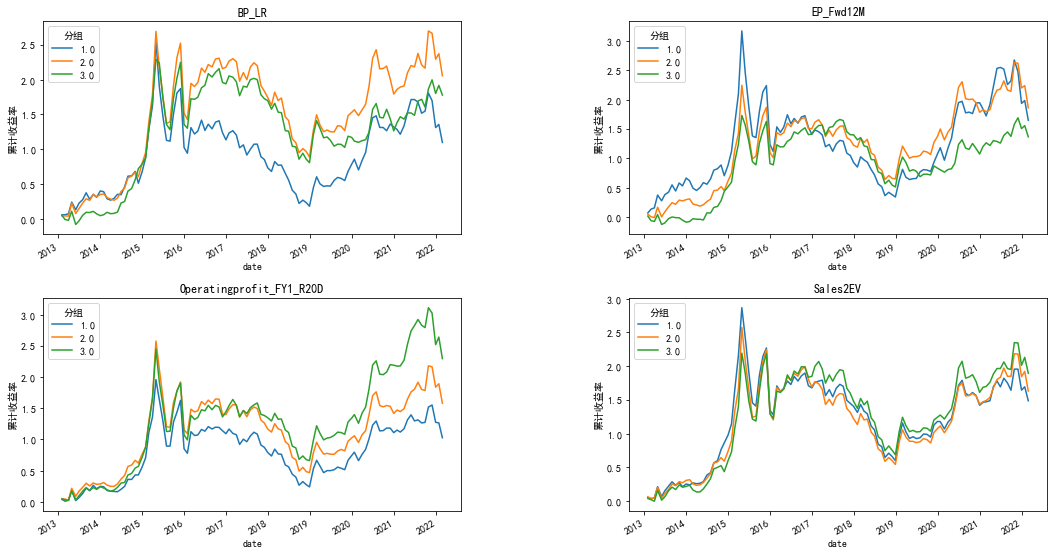

In [11]:
factors2 = ['BP_LR', 'EP_Ewd12M', 'Operatingprofit_FY1_R20D', 'Sales2EV']
direction2 = ['ascending', 'descending', 'ascending', 'ascending']
plotting_dichotomy_res(res1['成长期'])

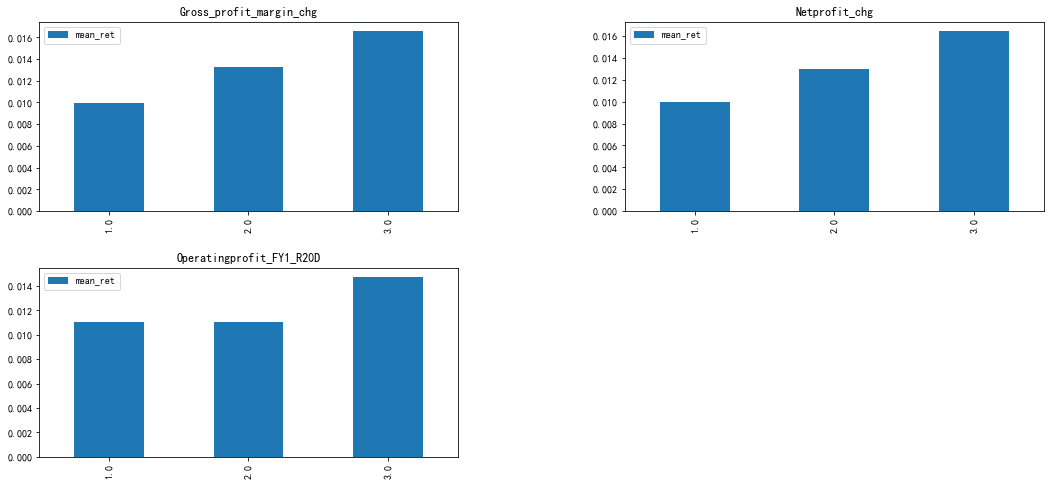

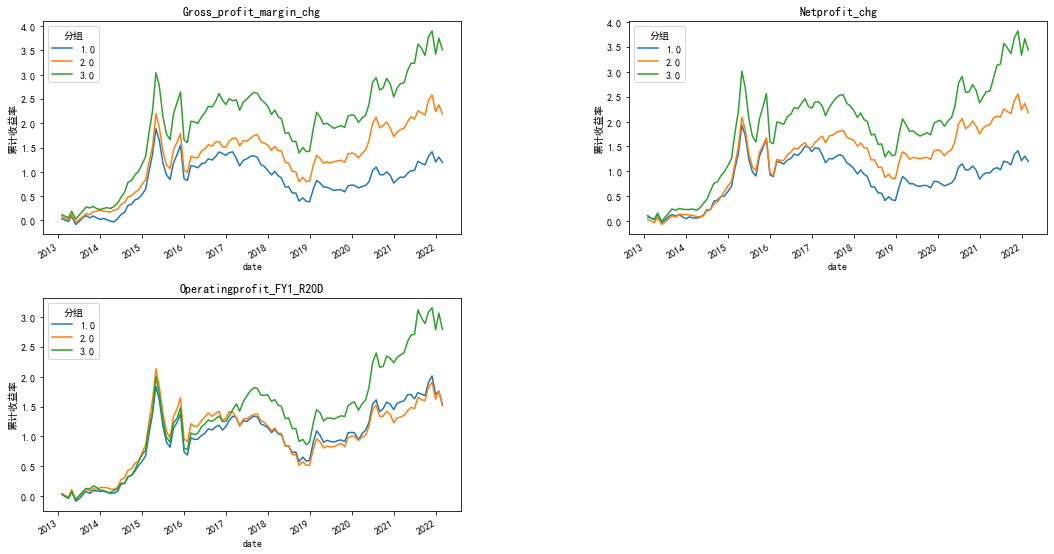

In [12]:
factors3 = [
    'Gross_profit_margin_chg', 'Netprofit_chg', 'Operatingprofit_FY1_R20D'
]
direction3 = ['ascending', 'ascending', 'ascending']
plotting_dichotomy_res(res1['成熟期'])

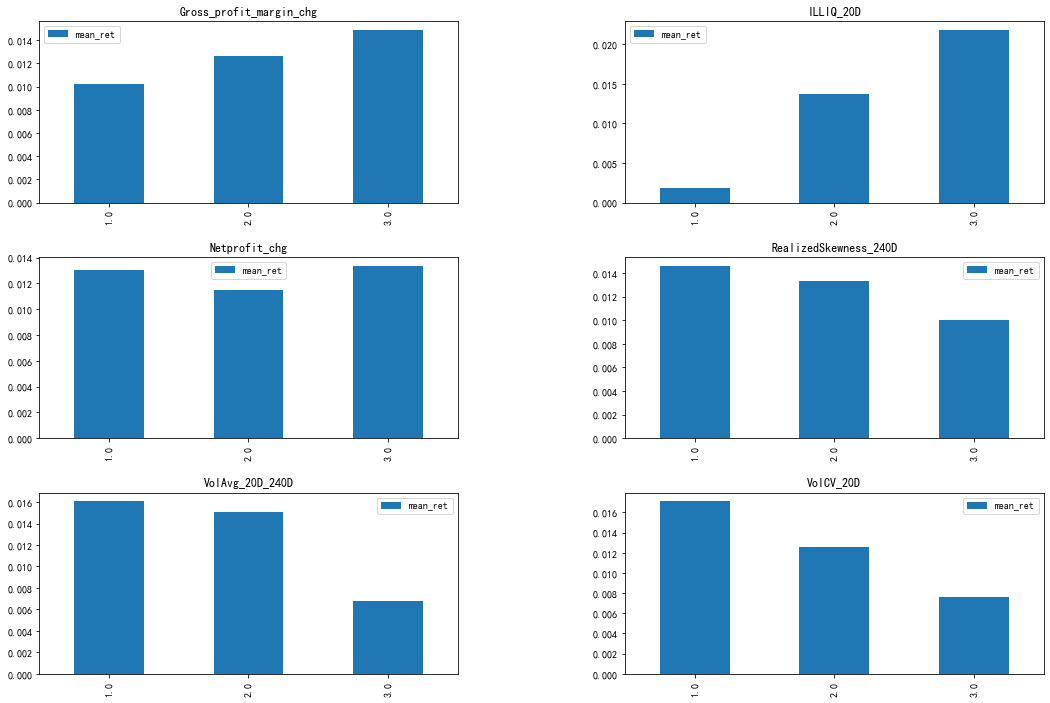

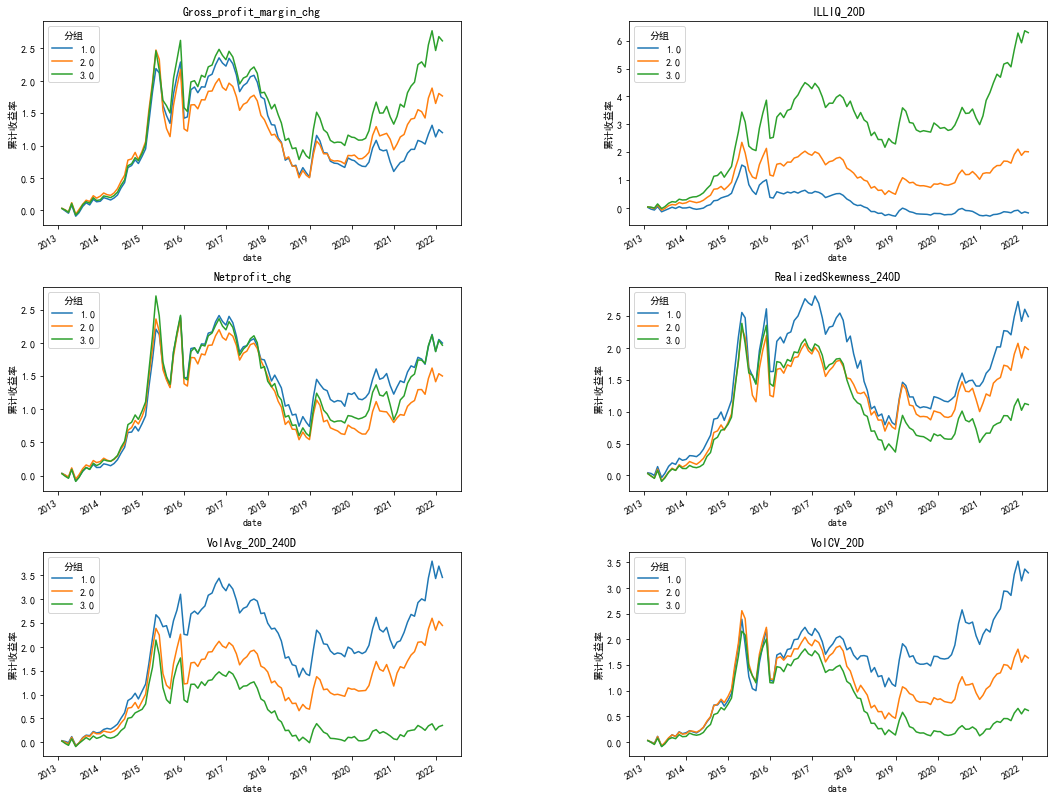

In [13]:
factors4 = [
    'Gross_profit_margin_chg', 'ILLIQ_20D', 'Netprofit_chg',
    'RealizedSkewness_240D', 'VolAvg_20D_240D', 'VolCV_20D'
]
direction4 = [
    'ascending', 'ascending', 'ascending', 'descending', 'descending',
    'descending'
]

plotting_dichotomy_res(res1['衰退期'])

# 因子复合

In [11]:
import composition_factor as comp_factor
import alphalens as al
import empyrical as ep
from my_scr import (get_group_return, add_group)


In [16]:
factors = factors_frame.copy()
next_ret = comp_factor.compute_forward_returns(pricing, (1, ))
factors['next_ret'] = next_ret[1]

In [5]:
factors1 = ( 'BP_LR', 'EP_Fwd12M', 'ILLIQ_20D', 'RealizedSkewness_240D', 'Sales2EV',
    'VolAvg_20D_240D', 'VolCV_20D')
   

direction1 = (
    'ascending', 'ascending', 'ascending', 'descending', 'descending',
    'descending', 'descending'
)

factors2 = ('BP_LR', 'EP_Ewd12M', 'Operatingprofit_FY1_R20D', 'Sales2EV')
direction2 = ('ascending', 'descending', 'ascending', 'ascending')

factors3 = (
    'Gross_profit_margin_chg', 'Netprofit_chg', 'Operatingprofit_FY1_R20D'
)
direction3 = ('ascending', 'ascending', 'ascending')

factors4 = (
    'Gross_profit_margin_chg', 'ILLIQ_20D', 'Netprofit_chg',
    'RealizedSkewness_240D', 'VolAvg_20D_240D', 'VolCV_20D'
)
direction4 = (
    'ascending', 'ascending', 'ascending', 'descending', 'descending',
    'descending'
)

direction = {
    name: dict(zip(k, v))
    for name, k, v in zip(('导入期', '成长期', '衰退期',
                           '成熟期'), (factors1, factors2, factors3,
                                    factors4), (direction1, direction2,
                                                direction3, direction4))
}


In [12]:
stack_quandrant = quandrant.stack().to_frame('cat_type')
res2 = get_factor_res(stack_quandrant,
                      factors_frame,
                      pricing,
                      quadrant_dic,
                      group_num=3,
                      direction=direction,
                      comp_params={'method':'fac_maxicir_ledoit',
                                   'window':5,
                                   'is_rank':False})


KeyError: 'method'

In [3]:
quadrant_dic

{'导入期': ('cat_type == 2',
  ['BP_LR',
   'RealizedSkewness_240D',
   'VolCV_20D',
   'ILLIQ_20D',
   'Sales2EV',
   'VolAvg_20D_240D',
   'EP_Fwd12M']),
 '成长期': ('cat_type == 1',
  ['BP_LR', 'Operatingprofit_FY1_R20D', 'EP_Fwd12M', 'Sales2EV']),
 '衰退期': ('cat_type == 3',
  ['RealizedSkewness_240D',
   'VolCV_20D',
   'Netprofit_chg',
   'ILLIQ_20D',
   'VolAvg_20D_240D',
   'Gross_profit_margin_chg']),
 '成熟期': ('cat_type == 4',
  ['Operatingprofit_FY1_R20D', 'Netprofit_chg', 'Gross_profit_margin_chg'])}

<AxesSubplot:xlabel='date'>

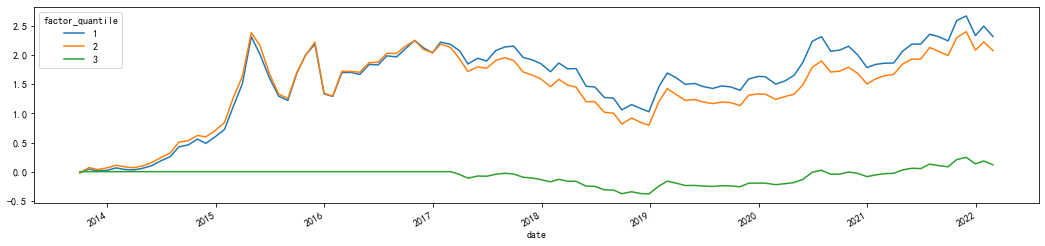

In [18]:
# 全样本
# 按观察结果排序后合成
score = comp_factor.factor_score_indicators(factors, 'maxicir_ledoit',
                                            factor_direction, 5)
group_df = add_group(score, 'score', 3)
score['factor_quantile'] = group_df['score']

group_ret = get_group_return(score, ['factor_quantile']).reset_index(level=0,
                                                                     drop=True)
group_cum = ep.cum_returns(group_ret)

group_cum.plot(figsize=(18, 4))


<AxesSubplot:xlabel='date'>

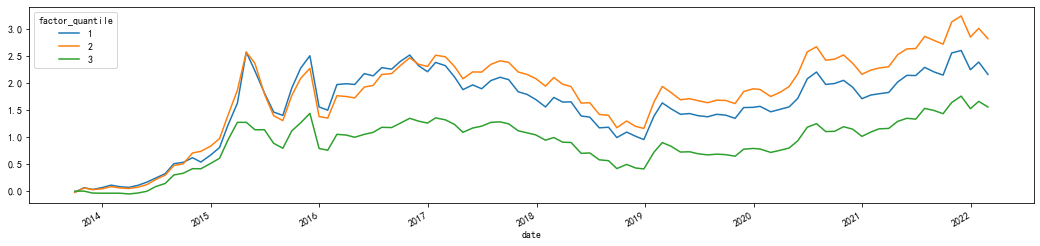

In [19]:
# 全样本
# 直接合成
score1 = comp_factor.fac_maxicir_ledoit(factors, 5)
group_df1 = add_group(score1, 'score', 3)
score1['factor_quantile'] = group_df1['score']
score1['next_ret'] = factors['next_ret']
group_ret1 = get_group_return(score1,
                              ['factor_quantile']).reset_index(level=0,
                                                               drop=True)
group_cum1 = ep.cum_returns(group_ret1)

group_cum1.plot(figsize=(18, 4))


<AxesSubplot:xlabel='date'>

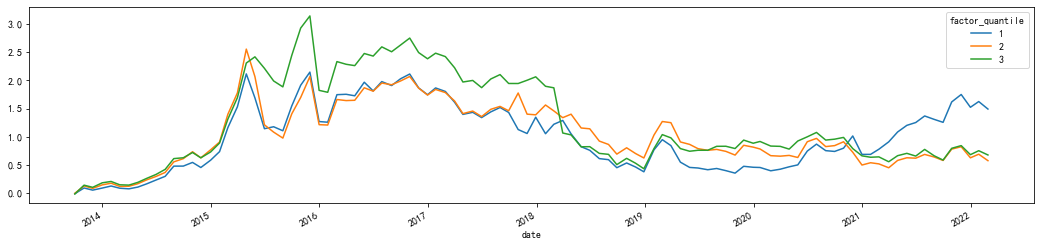

In [20]:
# 导入期
stack_quandrant = quandrant.stack().to_frame('cat_type')

quandrant1 = stack_quandrant.query('cat_type==2').index

quandrant_factor1 = factors.loc[quandrant1].copy()

score = comp_factor.factor_score_indicators(quandrant_factor1,
                                            'maxicir_ledoit', factor_direction,
                                            5)
group_df = add_group(score, 'score', 3)
score['factor_quantile'] = group_df['score']

group_ret = get_group_return(score, ['factor_quantile']).reset_index(level=0,
                                                                     drop=True)
group_cum = ep.cum_returns(group_ret)

group_cum.plot(figsize=(18, 4))


<AxesSubplot:xlabel='date'>

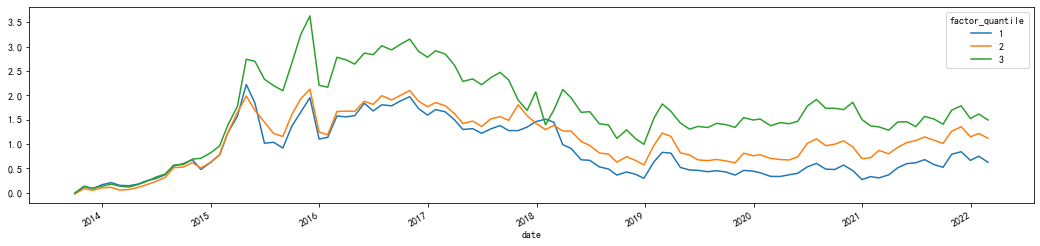

In [21]:
score1 = comp_factor.fac_maxicir_ledoit(quandrant_factor1, 5)
group_df1 = add_group(score1, 'score', 3)
score1['factor_quantile'] = group_df1['score']
score1['next_ret'] = quandrant_factor1['next_ret']
group_ret1 = get_group_return(score1,
                              ['factor_quantile']).reset_index(level=0,
                                                               drop=True)
group_cum1 = ep.cum_returns(group_ret1)

group_cum1.plot(figsize=(18, 4))
